In [4]:
import os
from glob import glob

import transformers
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

import torchvision
# from skimage import io
import cv2

import copy, json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

os.environ['TOKENIZERS_PARALLELISM'] = 'true'

/home/sit/phd/anz228400/.conda/envs/dl/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

options = ['0', '1', '2', '3', '4', '5', 'yes', 'no', 'rubber', 'metal', 'sphere', 'cube', 'cylinder', 'gray', 'brown', 'green', 'red', 'blue', 'purple', 'yellow', 'cyan']
option_id_map = {
    o:i for i,o in enumerate(options)
}
id_option_map = {
    i:o for i,o in enumerate(options)
}
task_heads = ['descriptive', 'explanatory', 'predictive', 'counterfactual']
binary_id_map = {'wrong': 0, 'correct': 1}
ques_dict_keys = ["tokens", "q_ids", "choice_ids"]

In [10]:
class ProcessQuestions:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        pass
        
    def get_qa_batch(self, ques_list):
        #TODO: get qa batches for the current task_head
        '''
        INPUT:
        ques_list: list of question_data dictionary
        OUTPUT: question_dict, answer_dict
        descriptive: 
            question_list: list of <question> [SEP] <question_subtype>
            answer_list: list of respective answer as option_id_map
        explanatory:
            question_list: list of <question> [SEP] <choice_k>
            answer_list: list of respective answer as binary_id_map correct = 1 / wrong = 0
        predictive:
            question_list: list of <question> [SEP] <choice_1 >  [SEP] <choice_2>
            answer_list: OHE vector of respective answer as binary_id_map correct = 1 / wrong = 0
        counterfactual:
            question_list: list of <question> [SEP] <choice_k>
            answer_list: list of respective answer as binary_id_map correct = 1 / wrong = 0
        '''
        
        question_dict = {i:{j:[] for j in ques_dict_keys} for i in task_heads}
        answer_dict = {i:[] for i in task_heads}
        for j, q in enumerate(ques_list):
            question_type = q['question_type']
            
            if question_type == "descriptive":
                question_dict[question_type]['tokens'].append(q['question'] + " [SEP] " + q['question_subtype'])
                question_dict[question_type]['q_ids'].append(q['question_id'])
                answer_dict[question_type].append(option_id_map[q['answer']])

            elif question_type == "explanatory":                
                question = q['question']
                q_id = q['question_id']                
                for c, choice in enumerate(q['choices']):
                    question_dict[question_type]['tokens'].append(question + " [SEP] " + choice['choice'])
                    question_dict[question_type]['q_ids'].append(q_id)
                    question_dict[question_type]['choice_ids'].append(choice['choice_id'])
                    answer_dict[question_type].append(binary_id_map[choice['answer']])

            elif question_type == "predictive":               
                question = q['question']
                q_id = q['question_id']                
                for c, choice in enumerate(q['choices']):
                    question_dict[question_type]['tokens'].append(question + " [SEP] " + choice['choice'])
                    question_dict[question_type]['q_ids'].append(q_id)
                    question_dict[question_type]['choice_ids'].append(choice['choice_id'])
                    answer_dict[question_type].append(binary_id_map[choice['answer']])
                
#                 question_dict[question_type].append(question + " [SEP] " + q['choices'][0]['choice'] + " [SEP] " + q['choices'][1]['choice'])               
#                 answer_dict[question_type].append(binary_id_map[q['choices'][1]['answer']]) #  binary_id_map[q['choices'][0]['answer']], binary_id_map[q['choices'][1]['answer']]])

            elif question_type == "counterfactual":               
                question = q['question']
                q_id = q['question_id']                
                for c, choice in enumerate(q['choices']):
                    question_dict[question_type]['tokens'].append(question + " [SEP] " + choice['choice'])
                    question_dict[question_type]['q_ids'].append(q_id)
                    question_dict[question_type]['choice_ids'].append(choice['choice_id'])
                    answer_dict[question_type].append(binary_id_map[choice['answer']])
        
        for th in task_heads:
            if answer_dict[th]:
                question_dict[th]['tokens'] = self.tokenizer(question_dict[th]['tokens'], return_tensors='pt', padding=True)
                question_dict[th]['q_ids'] = torch.tensor(question_dict[th]['q_ids'], dtype=torch.long)
                question_dict[th]['choice_ids'] = torch.tensor(question_dict[th]['choice_ids'], dtype=torch.long)
                answer_dict[th] = torch.tensor(answer_dict[th], dtype=torch.long)
                
                if th != 'descriptive':
                    answer_dict[th] = answer_dict[th].float()
            else:
                del question_dict[th]
                del answer_dict[th]
        
        return question_dict, answer_dict
        
class CLEVRERDataset(Dataset):
    
    def __init__(self, data_dir, frame_dir, tokenizer):
        # TODO load annotations
        assert os.path.isdir(data_dir)
        assert os.path.isdir(frame_dir)
        
        with open(os.path.join(data_dir, data_dir.split("/")[-1] + ".json"), "r") as f:
            self.json_data = json.load(f)
        self.frame_dir = frame_dir
        
        self.process_questions = ProcessQuestions(tokenizer)
        
    
    def __len__(self):
        # get length from directory
        return len(self.json_data)
    
    def __getitem__(self, idx):
        """
        TODO: 
        1. Change here hardcoded path in frame_paths to os.path.join(self.frame_dir, f"sim_{vid_id}", "*.png")
        2. Check normalization mean and std values used in image transform.
        """
        
        vid_json = self.json_data[idx]
        vid_id = vid_json['scene_index']
        
        frame_dir = os.path.join(self.frame_dir, f"sim_{vid_id:05d}", "*.png")
        frame_paths = sorted(glob(frame_dir))
        frames = torch.stack([torchvision.io.read_image(img).float() for img in frame_paths[::5]])
                
        ques_dict, ans_dict = self.process_questions.get_qa_batch(vid_json['questions'])

        return {'frames': frames, 'ques_dict': ques_dict, 'ans_dict': ans_dict}

In [7]:
def dl_collate_fn(data):
    return data[0]

def ques_to_device(d):
    return {k: {k_dash: v_dash.to(device) for k_dash, v_dash in v.items()} for k,v in d.items()}

def ans_to_device(d):
    return {k: v.to(device) for k,v in d.items()}

def process_example(example, transform):
    return {
        'frames': transform(example['frames'].to(device)),
        'ques_dict': ques_to_device(example['ques_dict']),
        'ans_dict': ans_to_device(example['ans_dict'])
    }

In [11]:
img_transform = torchvision.transforms.Compose([torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465),
                                                                     (0.2023, 0.1994, 0.2010))])
tokenizer = transformers.AutoTokenizer.from_pretrained('bert-base-cased')

train_ds = CLEVRERDataset("../../../../data/train", "../../../../clevrer_code/frames", tokenizer)
val_ds = CLEVRERDataset("../../../../data/validation", "../../../../clevrer_code/frames", tokenizer)
train_dl = DataLoader(train_ds, batch_size=1, collate_fn=dl_collate_fn, shuffle=True, num_workers=4)
val_dl = DataLoader(val_ds, batch_size=1, collate_fn=dl_collate_fn, shuffle=True, num_workers=4)

In [12]:
for example in tqdm(train_dl):
            
    example = process_example(example, img_transform)
    frames = example['frames']
    ques_dict = example['ques_dict']
    ans_dict = example['ans_dict']
    # print("Frames Shape:", frames.shape)
    
    # for th in task_heads:
    #     print("\n", th)
    #     print("answers:",ans_dict[th])
    #     for k in ques_dict_keys:
    #         if k != "tokens":
    #             print(f'{k}:', ques_dict[th][k])
    # break

  0%|            | 0/10000 [00:00<?, ?it/s]

128
128
128
128
128
128
128
128


  0%|  | 4/10000 [00:03<2:03:04,  1.35it/s]

128
128
128
128
128
128
128
128


  0%|  | 6/10000 [00:06<2:52:14,  1.03s/it]

128
128
128
128


  0%| | 12/10000 [00:09<1:36:27,  1.73it/s]

128
128
128


  0%| | 14/10000 [00:12<2:15:39,  1.23it/s]

128


  0%| | 15/10000 [00:12<2:04:09,  1.34it/s]

128
128
128


  0%| | 17/10000 [00:14<2:19:12,  1.20it/s]

128


  0%| | 19/10000 [00:15<1:53:16,  1.47it/s]

128
128
128


  0%| | 21/10000 [00:17<2:04:13,  1.34it/s]

128
128


  0%| | 23/10000 [00:18<2:05:13,  1.33it/s]

128
128
128


  0%| | 25/10000 [00:20<2:00:22,  1.38it/s]

128
128


  0%| | 27/10000 [00:21<1:54:47,  1.45it/s]

128


  0%| | 29/10000 [00:22<1:54:10,  1.46it/s]

128
128


  0%| | 31/10000 [00:23<1:43:19,  1.61it/s]

128
128


  0%| | 32/10000 [00:24<2:05:20,  1.33it/s]


KeyboardInterrupt: 

Traceback (most recent call last):
  File "/home/sit/phd/anz228400/.conda/envs/dl/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/sit/phd/anz228400/.conda/envs/dl/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/sit/phd/anz228400/.conda/envs/dl/lib/python3.7/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/sit/phd/anz228400/.conda/envs/dl/lib/python3.7/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
  File "/home/sit/phd/anz228400/.conda/envs/dl/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/home/sit/phd/anz228400/.conda/envs/dl/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 215, in start
    self.asyncio_loop.run_forever()
  File "/home/sit/phd/anz228400/.conda/envs/dl/lib/python3.7/asyncio/base_events.py", line 541, in run_

In [4]:
class DescriptiveTaskHead(nn.Module):
	
	def __init__(self, n_classes=21, p=0.2, input_dim=768*2):
		super().__init__()
		self.clf = nn.Sequential(
			nn.Linear(input_dim, 1024),
			nn.Dropout(p=0.2),
			nn.ReLU(),
			nn.Dropout(p=0.2),
			nn.Linear(1024, n_classes)
		)

	def forward(self, features):
		return self.clf(features)

class ExplanatoryTaskHead(nn.Module):
	
	def __init__(self, p=0.2, input_dim=768*2):
		super().__init__()
		self.clf = nn.Sequential(
			nn.Linear(input_dim, 1024),
			nn.Dropout(p=0.2),
			nn.ReLU(),
			nn.Dropout(p=0.2),
			nn.Linear(1024, 1),
            nn.Sigmoid()
		)

	def forward(self, features):
		return self.clf(features).squeeze()

class PredictiveTaskHead(nn.Module):
	
	def __init__(self, p=0.2, input_dim=768*2):
		super().__init__()
		self.clf = nn.Sequential(
			nn.Linear(input_dim, 1024),
			nn.Dropout(p=0.2),
			nn.ReLU(),
			nn.Dropout(p=0.2),
			nn.Linear(1024, 1)
		)

	def forward(self, features):
		return self.clf(features)

class CounterfactualTaskHead(nn.Module):
	
	def __init__(self, p=0.2, input_dim=768*2):
		super().__init__()
		self.clf = nn.Sequential(
			nn.Linear(input_dim, 1024),
			nn.Dropout(p=0.2),
			nn.ReLU(),
			nn.Dropout(p=0.2),
			nn.Linear(1024, 1),
            nn.Sigmoid()
		)

	def forward(self, features):
		return self.clf(features).squeeze()

In [5]:
class BertCNNModel(nn.Module):
    
    def __init__(self, hidden_size=768):
        super().__init__()
        self.cnn = torchvision.models.resnet50(pretrained=True)
        self.cnn.fc = nn.Identity()
        
        for name, param in self.cnn.named_parameters():
            if not name.startswith('layer4'):
                param.requires_grad = False
        
        self.lstm = nn.LSTM(
                input_size=2048,
                batch_first=True,
                hidden_size=hidden_size,
                num_layers=1
            )
        self.bert = transformers.BertModel.from_pretrained('bert-base-cased')
        
        self.h0 = nn.Parameter(torch.empty(1,hidden_size).normal_(0, 0.1))
        self.c0 = nn.Parameter(torch.empty(1,hidden_size).normal_(0, 0.1))
        
        self.descriptive_head = DescriptiveTaskHead()
        self.explanatory_head = ExplanatoryTaskHead()
        self.predictive_head = PredictiveTaskHead()
        self.counterfactual_head = CounterfactualTaskHead()
        
        self.head_map = {
            'descriptive': self.descriptive_head,
            'predictive': self.predictive_head,
            'explanatory': self.explanatory_head,
            'counterfactual': self.counterfactual_head
        }
        
    def forward(self, example):
        
        N, C, H, W = example['frames'].shape
        i = 0
        bs = 8
        frame_emb = []
        while (i*bs < N):
            frame_emb += [self.cnn(example['frames'][i*bs:(i+1)*bs])]
            i += 1
            
        frame_emb = torch.vstack(frame_emb)
        frame_encs, (video_enc, last_cell_state) = self.lstm(frame_emb, (self.h0, self.c0))
        
        # faster to batch everything and send, but this works for now
        preds = {}
        for task, questions in example['ques_dict'].items():

            bert_output = self.bert(**questions)

            # feature vector
            features = torch.hstack([video_enc.repeat(bert_output.pooler_output.size(0),1), bert_output.pooler_output])

            preds[task] = self.head_map[task](features)
        
        return preds

## Training

In [7]:
n_epochs=4

In [9]:
img_transform = torchvision.transforms.Compose([torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465),
                                                                     (0.2023, 0.1994, 0.2010))])
tokenizer = transformers.AutoTokenizer.from_pretrained('bert-base-cased')

train_ds = CLEVRERDataset("../../data/data/train", "../../clevrer_code/frames", tokenizer)
val_ds = CLEVRERDataset("../../data/data/validation", "../../clevrer_code/frames", tokenizer)

In [10]:
DEBUG = True
if DEBUG:
    train_ds.json_data = train_ds.json_data[:16]
    val_ds.json_data = val_ds.json_data[:8]

In [11]:
train_dl = DataLoader(train_ds, batch_size=1, collate_fn=dl_collate_fn, shuffle=True, num_workers=4)
val_dl = DataLoader(val_ds, batch_size=1, collate_fn=dl_collate_fn, shuffle=True, num_workers=4)

In [12]:
model = BertCNNModel().to(device)

/home/cse/btech/cs1200869/.conda/envs/dl_35/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/home/cse/btech/cs1200869/.conda/envs/dl_35/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.den

In [13]:
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [23]:
def train(model, train_dl, val_dl, optimizer, scheduler=None, max_epochs=10, patience_lim=2, ckpt_freq=2, ckpt_prefix='../models/baseline'):

    best_model = None
    best_val_loss = 10000
    val_losses = []
    train_losses = []
    val_question_count = {t:0 for t in task_heads}
    
    patience = 0
    
    loss_fns = {
        'descriptive': nn.CrossEntropyLoss(),
        'predictive': nn.BCELoss(),
        'explanatory': nn.BCELoss(),
        'counterfactual': nn.BCELoss()
    }
    
    for epoch in range(max_epochs):

        print(f"\n\n|----------- EPOCH: {epoch} -----------|")

        model.train()
        train_loss = 0
        for example in tqdm(train_dl):
            
            example = process_example(example, img_transform)

            optimizer.zero_grad()
            outputs = model(example)
            loss = 0
            for task, output in outputs.items():
                loss += loss_fns[task](output, example['ans_dict'][task])
            
            train_loss += loss.detach().cpu()
            
            loss.backward()
            optimizer.step()

        train_loss /= len(train_dl)
        train_losses.append(train_loss)
 
        model.eval()
        val_loss = 0
        for example in tqdm(val_dl):
            
            example = process_example(example, img_transform)

            outputs = model(example)
            loss = 0
            for task, output in outputs.items():
                loss += loss_fns[task](output, example['ans_dict'][task])
            
            val_loss += loss.detach().cpu()

        val_loss /= len(val_dl)
        val_losses.append(val_loss)
            
        if scheduler:
            scheduler.step()
        
        if (epoch+1)%ckpt_freq == 0:
            print('Checkpointing model...')
            torch.save(model, f'{ckpt_prefix}-{epoch+1}.pt')
            
        if val_loss >= best_val_loss:
            if patience >= patience_lim:
                break
            else:
                patience += 1
        else:
            patience = 0
            best_val_loss = val_loss

    return train_losses, val_losses


In [24]:
train_losses, val_losses = train(model, train_dl, val_dl, optimizer)



|----------- EPOCH: 0 -----------|


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]



|----------- EPOCH: 1 -----------|


  0%|          | 0/16 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2ad7931b5830>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2ad7931b5830>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/cse/btech/cs1200869/.conda/envs/dl_35/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1481, in __del__
  File "/home/cse/btech/cs1200869/.conda/envs/dl_35/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1481, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x2ad7931b5830>self._shutdown_workers()Exception ignored in:     self._shutdown_workers()

<function _MultiProcessingDataLoaderIter.__del__ at 0x2ad7931b5830>  File "/home/cse/btech/cs1200869/.conda/envs/dl_35/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
  File "/home/cse/btech/cs1200869/.conda/envs/dl_35/lib/python3.7/site-packages/torch/utils/data/da

  0%|          | 0/8 [00:00<?, ?it/s]

Checkpointing model...


|----------- EPOCH: 2 -----------|


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]



|----------- EPOCH: 3 -----------|


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Checkpointing model...


|----------- EPOCH: 4 -----------|


  0%|          | 0/16 [00:00<?, ?it/s]

KeyboardInterrupt: 

TypeError: unhashable type: 'dict'

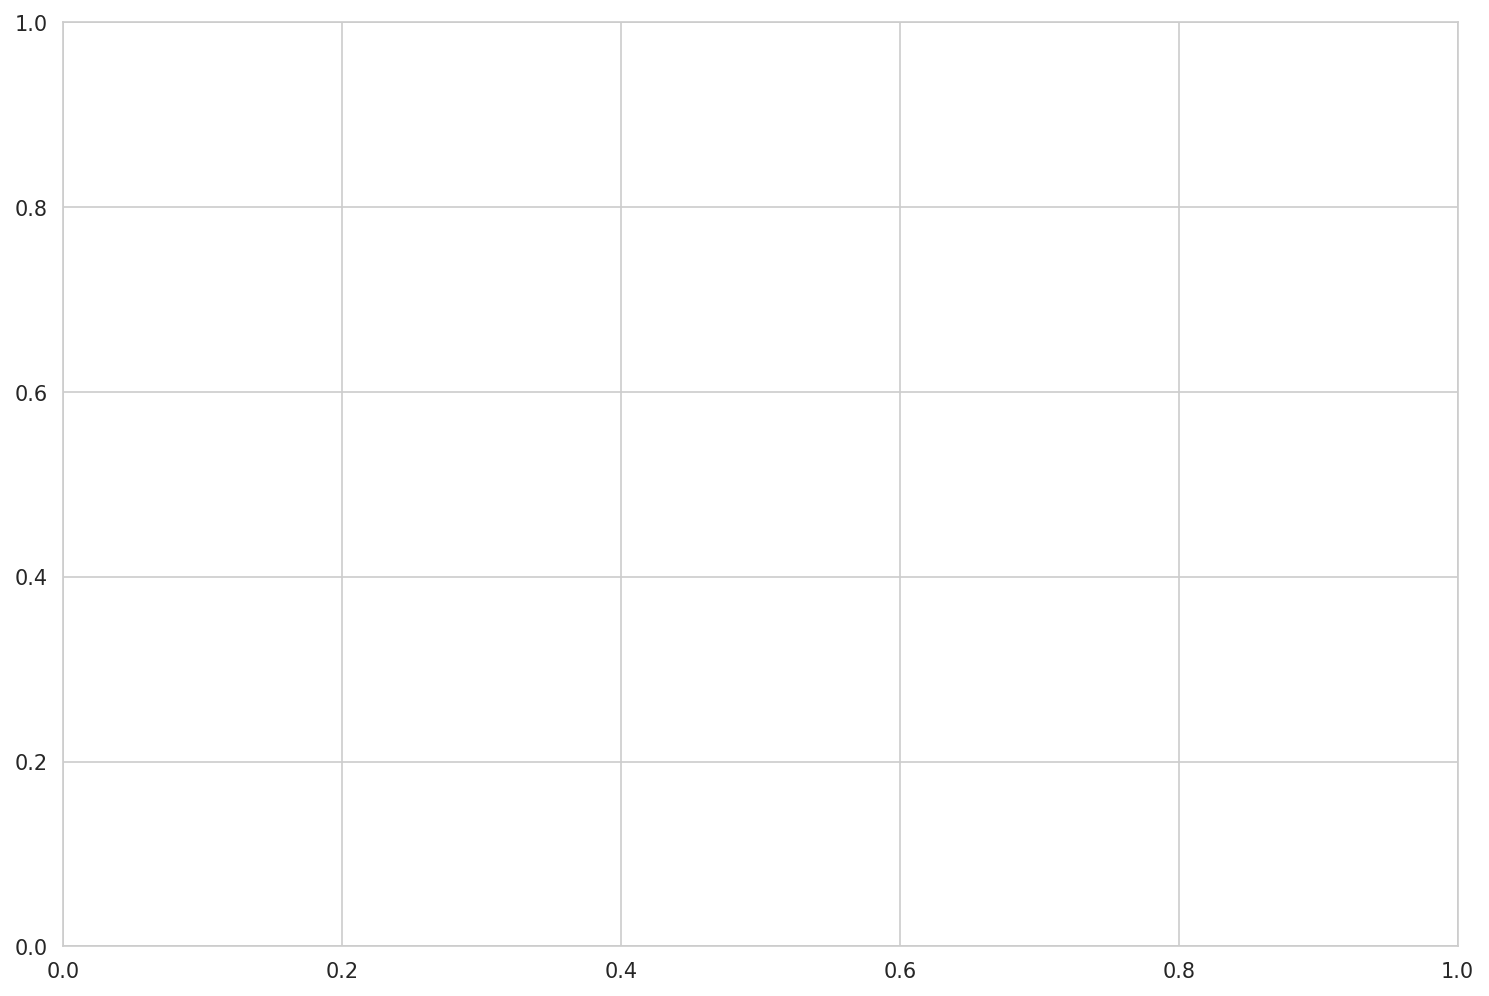

In [27]:
plt.figure(figsize=(12,8), dpi=150)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.savefig('loss_curve.pdf')